<a href="https://colab.research.google.com/github/phamngochieu123456/HK_Race/blob/master/HK_Race_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [223]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.activations import softmax
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

# Base Model

In [224]:
runs_df = pd.read_csv(r"/content/runs.csv", delimiter=",", header=0)
runs_df = runs_df[['race_id', 'draw', 'horse_age', 'horse_country', 'horse_type',
                   'horse_rating', 'declared_weight', 'actual_weight', 'win_odds',
                   'place_odds', 'result']]
drop_index = runs_df[runs_df['race_id'] == 5188].index
runs_df = runs_df.drop(drop_index)

horse_country_encoder = preprocessing.LabelEncoder()
runs_df['horse_country'] = pd.Series(horse_country_encoder.fit_transform(
    runs_df['horse_country'][runs_df['horse_country'].notnull()]),
                                     index=runs_df['horse_country'][runs_df['horse_country'].notnull()].index)

horse_type_encoder = preprocessing.LabelEncoder()
runs_df['horse_type'] = pd.Series(horse_type_encoder.fit_transform(
    runs_df['horse_type'][runs_df['horse_type'].notnull()]),
                                     index=runs_df['horse_type'][runs_df['horse_type'].notnull()].index)

imputer = KNNImputer(n_neighbors=20)
runs_df_numpy = imputer.fit_transform(runs_df)

runs_df = pd.DataFrame(data=runs_df_numpy, columns=runs_df.columns, index=runs_df.index)

In [225]:
np.where(runs_df.isnull())

(array([], dtype=int64), array([], dtype=int64))

In [226]:
races_df = pd.read_csv(r"/content/races.csv", delimiter=",", header=0)
races_df = races_df[['race_id', 'venue', 'config', 'surface', 'distance', 'going', 'race_class']]

config_encoder = preprocessing.OrdinalEncoder()
races_df['config'] = config_encoder.fit_transform(races_df['config'].values.reshape(-1, 1))
going_encoder = preprocessing.OrdinalEncoder()
races_df['going'] = going_encoder.fit_transform(races_df['going'].values.reshape(-1, 1))

venue_encoder = preprocessing.LabelEncoder()
races_df['venue'] = venue_encoder.fit_transform(races_df['venue'])

In [227]:
np.where(races_df.isnull())

(array([], dtype=int64), array([], dtype=int64))

In [228]:
data = runs_df.merge(races_df, how='inner', on='race_id')

In [229]:
np.where(data.isnull())

(array([], dtype=int64), array([], dtype=int64))

In [260]:
use_column = ['race_id', 'result', 'draw']
use_column_pre = ['result', 'draw']

In [261]:
gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 42).split(data, groups=data['race_id'])

X_train_inds, X_test_inds = next(gss)

train_data= data.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(use_column)]
y_train = train_data.loc[:, train_data.columns.isin(['result'])]

groups = train_data.groupby('race_id').size().to_frame('size')['size'].to_numpy()

test_data= data.iloc[X_test_inds]

X_test = test_data.loc[:, ~test_data.columns.isin(use_column)]
y_test = test_data.loc[:, test_data.columns.isin(['result'])]

In [262]:
model = xgb.XGBRanker(
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.5,
    eta=0.05,
    max_depth=6,
    n_estimators=200,
    subsample=0.75
    )

model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.5,
          early_stopping_rounds=None, enable_categorical=False, eta=0.05,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=200, n_jobs=None,
          num_parallel_tree=None, predictor=None, ...)

In [263]:
def predict(model, df):
    array = model.predict(df.loc[:, ~df.columns.isin(['race_id'])])
    return array.argsort().argsort() + 1

In [264]:
predictions_train = (
    train_data.loc[:, ~train_data.columns.isin(use_column_pre)]
    .groupby('race_id').apply(lambda x: predict(model, x)))

y_true_train = train_data.loc[:, train_data.columns.isin(['race_id', 'result'])]
y_true_train = y_true_train.groupby('race_id').apply(lambda x: x['result'].to_numpy(dtype=int))

predictions_test = (
    test_data.loc[:, ~test_data.columns.isin(use_column_pre)]
    .groupby('race_id').apply(lambda x: predict(model, x)))

y_true_test = test_data.loc[:, test_data.columns.isin(['race_id', 'result'])]
y_true_test = y_true_test.groupby('race_id').apply(lambda x: x['result'].to_numpy(dtype=int))

In [265]:
def calculate_top3_error(y_true, predictions):
    total_races = len(y_true)
    correct_predictions = 0

    for race_id, true_positions in y_true.items():
        true_pos = np.where(true_positions == 1)[0][0]
        top3_pred = predictions[race_id].argsort()[:3]
        if true_pos in top3_pred:
            correct_predictions += 1

    top3_error = correct_predictions / total_races
    return top3_error

In [266]:
top3_error_train = calculate_top3_error(y_true_train, predictions_train)
top3_error_test = calculate_top3_error(y_true_test, predictions_test)
print(f"Top-3 Error Train: {top3_error_train:.4f}")
print(f"Top-3 Error Test: {top3_error_test:.4f}")

Top-3 Error Train: 0.6165
Top-3 Error Test: 0.6102


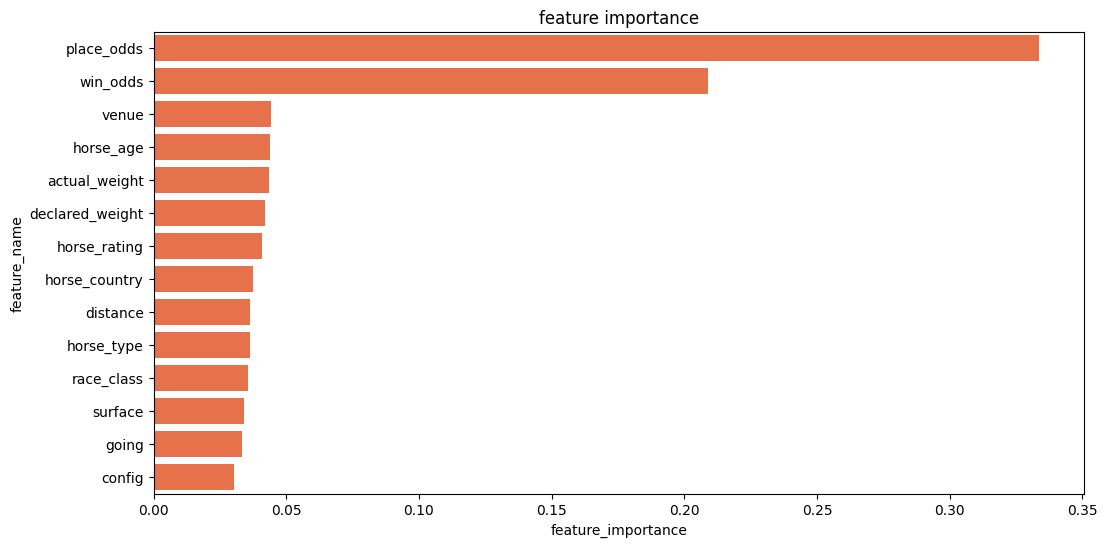

In [267]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()